# Conditional Score-based Diffusion Models for Time Series Imputation

This notebook investigates the application of Conditional Score-based Diffusion Models (CSDI) to time series imputation. Developed by researchers at Stanford University, CSDI adapts diffusion model principles, primarily used in image and audio synthesis, to effectively handle missing data in time series. Conditional Score-based Diffusion models for Imputation (CSDI) is a novel approach for imputing missing values in time series data by leveraging the power of score-based diffusion models. These models have shown remarkable success in various generative tasks, such as image and audio synthesis, and are now adapted for time series imputation.

## Background
Time series data, especially in healthcare and finance, often contain gaps resulting from sensor failures or incomplete data capture. Traditional imputation methods typically overlook the complex temporal dependencies inherent in time series data. CSDI addresses these challenges by using a conditional diffusion process to impute missing values, leveraging observed data to guide the imputation process.

## Objectives
- Introduce the theoretical framework and operation of CSDI.
- Implement the CSDI model using PyTorch to showcase its application on real-world datasets.
- Assess CSDI's performance in imputing missing values compared to conventional imputation techniques.

Through the exploration of CSDI's implementation and its imputation efficacy, this notebook aims to highlight its potential in improving the accuracy and reliability of time series analysis.

#### Overview of CSDI

CSDI utilizes a conditional diffusion model trained specifically for imputation tasks. Unlike traditional score-based models, which often approximate the conditional distribution, CSDI explicitly models the conditional distribution of missing values given observed data. This allows CSDI to better capture correlations and dependencies within the time series, leading to more accurate imputations.

#### Key Components of CSDI

1. **Forward Process**:
   - The forward process gradually adds noise to the observed time series data, transforming it into a distribution of latent variables. This is achieved through a series of Markov transitions defined by a small noise parameter, β.
   - Over several steps, this process creates increasingly noisy versions of the original data.

2. **Reverse Process**:
   - The reverse process aims to denoise the noisy latent variables back into a plausible time series conditioned on the observed data.
   - This process is governed by a parameterized function that gradually removes noise, conditioned on the observed values.

3. **Self-Supervised Training**:
   - CSDI is trained using a self-supervised approach inspired by masked language modeling. In practice, ground-truth missing values are unknown, so the model is trained by masking parts of the observed data and treating them as targets for imputation.
   - This loss encourages the model to accurately predict the noise added to the data, effectively learning to impute missing values.

#### Procedure of Time Series Imputation with CSDI

The imputation process with CSDI involves starting from random noise and gradually converting it into plausible time series data through the reverse process, conditioned on the observed values.

![Figure 1: Procedure of Time Series Imputation with CSDI](fig1.png)

*Figure 1 illustrates the imputation procedure. The reverse process \( p_\theta \) gradually removes noise from the noisy input, conditioned on observed values.*

#### Self-Supervised Training Procedure

During training, observed values are separated into conditional information and imputation targets. This separation allows the model to learn how to impute missing values by focusing on the observed data.

![Figure 2: Self-Supervised Training Procedure of CSDI](fig2.png)

*Figure 2 depicts the self-supervised training procedure. The observed values (green) are split into imputation targets (red) and conditional observations (blue).*

#### Attention Mechanism

To capture temporal and feature dependencies within the multivariate time series, CSDI employs a two-dimensional attention mechanism in each residual layer. This involves a temporal Transformer layer and a feature Transformer layer, allowing the model to learn dependencies across both time and features.

![Figure 3: Architecture of 2D Attention Mechanism](fig3.png)

*Figure 3 shows the architecture of the 2D attention mechanism. The temporal Transformer layer learns temporal dependencies, while the feature Transformer layer captures feature dependencies.*

#### Applications and Performance

CSDI has demonstrated superior performance in various imputation tasks, including:
- **Probabilistic Imputation**: Achieving significant improvements in continuous ranked probability score (CRPS) over existing methods.
- **Deterministic Imputation**: Reducing mean absolute error (MAE) compared to state-of-the-art deterministic imputation methods.
- **Time Series Interpolation and Forecasting**: Providing competitive results in these related tasks, showcasing its flexibility and robustness.

The architecture of CSDI employs an attention mechanism to capture temporal and feature dependencies within the time series, further enhancing its imputation capabilities.

For more details and implementation, refer to the [CSDI repository](https://github.com/ermongroup/CSDI).

## Library Imports and Model Setup

In this section, we import necessary libraries and modules required for the implementation of the CSDI model. This includes standard data handling libraries like `numpy` and `pandas`, deep learning libraries from `torch`, and specific components for building and training the CSDI model.

In [1]:
import os
import sys
import argparse
import torch
import torch.nn as nn
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# Add the parent directory to sys.path to import local modules
os.chdir('/h/gsharma/diffusion_model_bootcamp/reference_implementations/time_series_reference_impelementation/CSDI')

# from main_model import CSDI_Physio
from dataset_physio import get_dataloader
from utils import train, evaluate
from diff_models import diff_CSDI
from main_model import CSDI_Physio

## Download Dataset

Run this cell to download the physio dataset if you haven't already.

In [2]:
!python download.py physio

100% [......................................................] 6632372 / 6632372

## Experiment Setup and Execution for CSDI Model 

This segment highlights the setup and execution of utilizing CSDI for time series imputation of physiological data. Below is an overview of its components and their functionalities:

### **Imports and Module Loading**
- **Libraries and Modules**: The script begins by importing necessary Python libraries for handling configurations, data manipulations, neural network operations, and file system interactions. Custom modules specific to the CSDI model such as data loaders, training, and evaluation functions are also loaded.

### **Configuration and Argument Parsing**
- **Configuration File**: The experiment's settings are loaded from a YAML configuration file, allowing easy adjustments to the model and training parameters. Modifications to these settings via command line arguments are directly reflected in the configuration, ensuring that each experiment can be finely tuned.

### **Output Directory Setup**
- **Directory Creation**: The script automatically generates a directory based on the current timestamp and fold number for cross-validation. This structured approach to output management keeps results organized and separated based on experimental conditions, crucial for analysis and comparison of results.
- **Configuration Saving**: The final configuration used for the experiment is saved in the created directory, promoting reproducibility and detailed documentation of experimental conditions.

### **Data Preparation**
- **Data Loaders**: Structured data loaders are prepared for the training, validation, and testing phases, considering factors like batch size and the ratio of missing data, ensuring consistent and correct data handling throughout the experiment.

### **Model Handling**
- **Model Initialization**: The CSDI model is initialized and configured based on the loaded settings and is prepared for deployment on the specified compute device.
- **Conditional Training**: The script provides options to either train the model from scratch or load a pre-trained model, offering flexibility for continued training or fine-tuning of previously trained models.

### **Model Training and Evaluation**
- **Training**: The model undergoes training using the specified settings, with progress and outputs managed through the structured data loaders.
- **Evaluation**: Independently of training, the model is evaluated to assess its performance, particularly focusing on its ability to impute missing values in physiological time series data, with results documented and stored in the designated output directory.



In [2]:
def load_config(config_path='config/base.yaml'):
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    return config

config = load_config()
print(config)

{'train': {'epochs': 200, 'batch_size': 16, 'lr': 0.001, 'itr_per_epoch': 100000000.0}, 'diffusion': {'layers': 4, 'channels': 64, 'nheads': 8, 'diffusion_embedding_dim': 128, 'beta_start': 0.0001, 'beta_end': 0.5, 'num_steps': 50, 'schedule': 'quad', 'is_linear': False}, 'model': {'is_unconditional': 0, 'timeemb': 128, 'featureemb': 16, 'target_strategy': 'random'}}


## Data Handling and Preprocessing 

This section outlines the procedures and components involved in processing physiological time series data for the purpose of time series imputation:

- **extract_hour**: Converts timestamp strings from the dataset into numerical hours of the day. This numerical representation is crucial for aligning and analyzing time series data across multiple days.

- **parse_data**: Processes individual data frames by extracting the last recorded values for a predefined list of attributes. This function fills missing entries with `NaN`, facilitating the creation of a comprehensive feature matrix for each patient over the designated timeframe.

- **parse_id**: Manages data for individual patients by generating arrays of observed values and corresponding masks that indicate actual data points. It introduces controlled randomness in data availability by applying a missing data ratio, which mimics real-world scenarios of incomplete data, enhancing the model's ability to handle such occurrences effectively.

- **get_idlist**: Retrieves a list of patient IDs by scanning a specified directory for data files, ensuring all available data is accounted for and prepared for further processing.

- **Physio_Dataset**: Implements a custom dataset class for physiological data, which handles tasks such as loading, normalizing, and batching the data efficiently. It allows for the dynamic creation of datasets from raw data or loading from preprocessed files, supporting robust data handling within the PyTorch framework.

- **get_dataloader**: Sets up DataLoaders for different phases of model training and evaluation—training, validation, and testing. This function facilitates the division of data into subsets for cross-validation, ensuring each subset is properly shuffled and batched according to the model's requirements.

These components work together to ensure that the data is accurately prepared and readily available for implementing and training the imputation model, optimizing the workflow from raw data handling to model application.


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set up model
model = CSDI_Physio(config, device).to(device)

# Set up dataloaders
train_loader, valid_loader, test_loader = get_dataloader(
    seed=1,
    nfold=0,
    batch_size=config['train']['batch_size'],
    missing_ratio=config['model'].get('test_missing_ratio', 0.1)
)

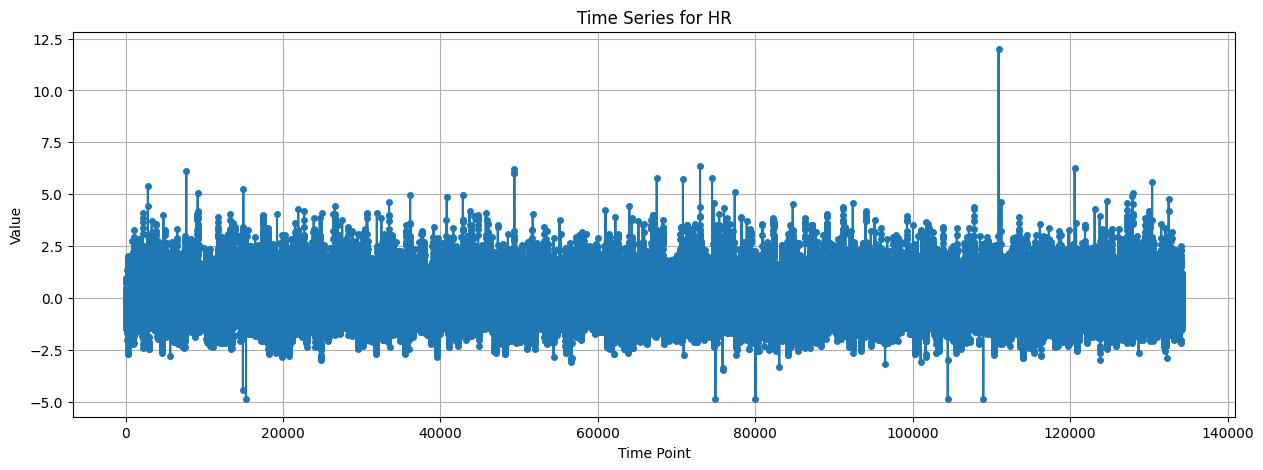

In [5]:

attributes = ['DiasABP', 'HR', 'Na', 'Lactate', 'NIDiasABP', 'PaO2', 'WBC', 'pH', 'Albumin', 'ALT', 'Glucose', 'SaO2',
              'Temp', 'AST', 'Bilirubin', 'HCO3', 'BUN', 'RespRate', 'Mg', 'HCT', 'SysABP', 'FiO2', 'K', 'GCS',
              'Cholesterol', 'NISysABP', 'TroponinT', 'MAP', 'TroponinI', 'PaCO2', 'Platelets', 'Urine', 'NIMAP',
              'Creatinine', 'ALP']

def plot_time_series(loader, attribute_index):
    all_values = []
    
    for batch in loader:
        all_values.append(batch['observed_data'][:, :, attribute_index])

    # Concatenate along the first axis (batch dimension)
    values = np.concatenate(all_values, axis=0)
    
    # Generate times assuming each timepoint in the batch is sequential and batches are continuous
    times = np.arange(values.shape[0] * values.shape[1])  # This creates a continuous time series across batches

    plt.figure(figsize=(15, 5))
    plt.plot(times, values.flatten(), marker='o', linestyle='-', markersize=4)
    plt.title(f'Time Series for {attributes[attribute_index]}')
    plt.xlabel('Time Point')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

#Plot time series for the first attribute HR
plot_time_series(train_loader, 1)


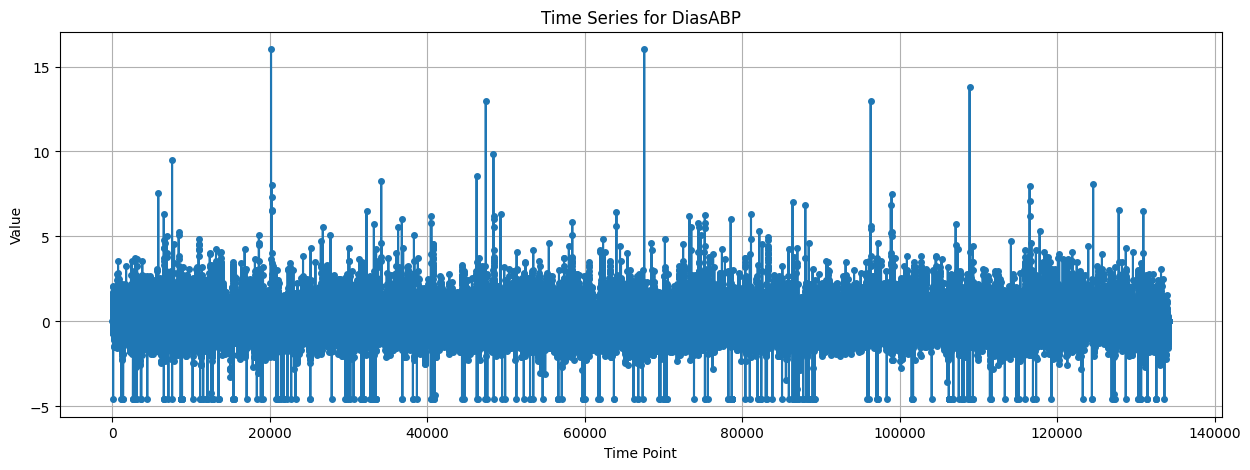

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_time_series(loader, attribute_index):
    all_values = []
    
    for batch in loader:
        # This assumes each batch['observed_data'] is of shape (batch_size, 48, 35)
        # and batch['timepoints'] is of shape (batch_size, 48)
        all_values.append(batch['observed_data'][:, :, attribute_index])

    # Concatenate along the first axis (batch dimension)
    values = np.concatenate(all_values, axis=0)
    
    # Generate times assuming each timepoint in the batch is sequential and batches are continuous
    times = np.arange(values.shape[0] * values.shape[1])  # This creates a continuous time series across batches

    plt.figure(figsize=(15, 5))
    plt.plot(times, values.flatten(), marker='o', linestyle='-', markersize=4)
    plt.title(f'Time Series for {attributes[attribute_index]}')
    plt.xlabel('Time Point')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

#Plot time series for the first attribute (DiasABP)
plot_time_series(train_loader, 0)


## Building the Diffusion Model

This section outlines the implementation details of the neural network components that form the backbone of the CSDI for time series imputation i.e. diffusion model. 

### Transformer Layers for Long-range Dependencies
The `get_torch_trans` and `get_linear_trans` functions are designed to construct transformer layers, which are important for CSDI's ability to capture long-range dependencies within data sequences. `get_torch_trans` creates a standard transformer encoder that utilizes multiple attention heads to process various segments of the input data concurrently. Conversely, `get_linear_trans` sets up a transformer using linear attention mechanisms to manage longer sequences efficiently by reducing computational overhead, which is beneficial for scalability and performance in large datasets.

### Customized Convolutional Layer Initialization
The initialization of convolutional layers through `Conv1d_with_init` uses the Kaiming normalization method to ensure consistent variance of activations, promoting stable learning dynamics across the model's layers. These convolutional layers are essential for extracting localized features from data, aiding the transformer layers in detailed pattern recognition.

### Embedding Temporal Dynamics with Diffusion Embedding
The `DiffusionEmbedding` class provides a method to embed the diffusion steps used in CSDI into a high-dimensional space using sinusoidal functions. This embedding is integral to the model, as it enables the precise modeling of how data evolves through the diffusion process, which is central to the score-based generative approach of CSDI.

### Model Architecture
The `diff_CSDI` class encapsulates the complete model structure, integrating diffusion embeddings with transformer and convolutional layers. This class demonstrates the application of advanced neural network techniques to build a robust architecture for time series imputation. It is specifically tailored to exploit both the temporal and feature-wise dependencies within data, leveraging the unique properties of diffusion models for effective imputation.

### Residual Blocks for Enhanced Learning
Within `diff_CSDI`, the `ResidualBlock` utilizes a dual-path approach to process information across both time and feature dimensions independently, allowing the model to capture complex interactions in the data. This design enhances the model's predictive accuracy and is a key component of the CSDI architecture, reflecting its capability to adapt and learn from multi-dimensional time series data effectively.

These components collectively form a sophisticated framework designed for the CSDI model, showcasing how theoretical advancements in machine learning can be practically applied to solve challenges in time series imputation with high efficiency and adaptability.


In [7]:
class CSDI_base(nn.Module):
    def __init__(self, target_dim, config, device):
        super().__init__()
        self.device = device
        self.target_dim = target_dim

        self.emb_time_dim = config["model"]["timeemb"]
        self.emb_feature_dim = config["model"]["featureemb"]
        self.is_unconditional = config["model"]["is_unconditional"]
        self.target_strategy = config["model"]["target_strategy"]

        self.emb_total_dim = self.emb_time_dim + self.emb_feature_dim
        if self.is_unconditional == False:
            self.emb_total_dim += 1  # for conditional mask
        self.embed_layer = nn.Embedding(
            num_embeddings=self.target_dim, embedding_dim=self.emb_feature_dim
        )

        config_diff = config["diffusion"]
        config_diff["side_dim"] = self.emb_total_dim

        input_dim = 1 if self.is_unconditional == True else 2
        self.diffmodel = diff_CSDI(config_diff, input_dim)

        # parameters for diffusion models
        self.num_steps = config_diff["num_steps"]
        if config_diff["schedule"] == "quad":
            self.beta = np.linspace(
                config_diff["beta_start"] ** 0.5, config_diff["beta_end"] ** 0.5, self.num_steps
            ) ** 2
        elif config_diff["schedule"] == "linear":
            self.beta = np.linspace(
                config_diff["beta_start"], config_diff["beta_end"], self.num_steps
            )

        self.alpha_hat = 1 - self.beta
        self.alpha = np.cumprod(self.alpha_hat)
        self.alpha_torch = torch.tensor(self.alpha).float().to(self.device).unsqueeze(1).unsqueeze(1)

    def time_embedding(self, pos, d_model=128):
        pe = torch.zeros(pos.shape[0], pos.shape[1], d_model).to(self.device)
        position = pos.unsqueeze(2)
        div_term = 1 / torch.pow(
            10000.0, torch.arange(0, d_model, 2).to(self.device) / d_model
        )
        pe[:, :, 0::2] = torch.sin(position * div_term)
        pe[:, :, 1::2] = torch.cos(position * div_term)
        return pe

    def get_randmask(self, observed_mask):
        rand_for_mask = torch.rand_like(observed_mask) * observed_mask
        rand_for_mask = rand_for_mask.reshape(len(rand_for_mask), -1)
        for i in range(len(observed_mask)):
            sample_ratio = np.random.rand()  # missing ratio
            num_observed = observed_mask[i].sum().item()
            num_masked = round(num_observed * sample_ratio)
            rand_for_mask[i][rand_for_mask[i].topk(num_masked).indices] = -1
        cond_mask = (rand_for_mask > 0).reshape(observed_mask.shape).float()
        return cond_mask

    def get_hist_mask(self, observed_mask, for_pattern_mask=None):
        if for_pattern_mask is None:
            for_pattern_mask = observed_mask
        if self.target_strategy == "mix":
            rand_mask = self.get_randmask(observed_mask)

        cond_mask = observed_mask.clone()
        for i in range(len(cond_mask)):
            mask_choice = np.random.rand()
            if self.target_strategy == "mix" and mask_choice > 0.5:
                cond_mask[i] = rand_mask[i]
            else:  # draw another sample for histmask (i-1 corresponds to another sample)
                cond_mask[i] = cond_mask[i] * for_pattern_mask[i - 1] 
        return cond_mask

    def get_test_pattern_mask(self, observed_mask, test_pattern_mask):
        return observed_mask * test_pattern_mask


    def get_side_info(self, observed_tp, cond_mask):
        B, K, L = cond_mask.shape

        time_embed = self.time_embedding(observed_tp, self.emb_time_dim)  # (B,L,emb)
        time_embed = time_embed.unsqueeze(2).expand(-1, -1, K, -1)
        feature_embed = self.embed_layer(
            torch.arange(self.target_dim).to(self.device)
        )  # (K,emb)
        feature_embed = feature_embed.unsqueeze(0).unsqueeze(0).expand(B, L, -1, -1)

        side_info = torch.cat([time_embed, feature_embed], dim=-1)  # (B,L,K,*)
        side_info = side_info.permute(0, 3, 2, 1)  # (B,*,K,L)

        if self.is_unconditional == False:
            side_mask = cond_mask.unsqueeze(1)  # (B,1,K,L)
            side_info = torch.cat([side_info, side_mask], dim=1)

        return side_info

    def calc_loss_valid(
        self, observed_data, cond_mask, observed_mask, side_info, is_train
    ):
        loss_sum = 0
        for t in range(self.num_steps):  # calculate loss for all t
            loss = self.calc_loss(
                observed_data, cond_mask, observed_mask, side_info, is_train, set_t=t
            )
            loss_sum += loss.detach()
        return loss_sum / self.num_steps

    def calc_loss(
        self, observed_data, cond_mask, observed_mask, side_info, is_train, set_t=-1
    ):
        B, K, L = observed_data.shape
        if is_train != 1:  # for validation
            t = (torch.ones(B) * set_t).long().to(self.device)
        else:
            t = torch.randint(0, self.num_steps, [B]).to(self.device)
        current_alpha = self.alpha_torch[t]  # (B,1,1)
        noise = torch.randn_like(observed_data)
        noisy_data = (current_alpha ** 0.5) * observed_data + (1.0 - current_alpha) ** 0.5 * noise

        total_input = self.set_input_to_diffmodel(noisy_data, observed_data, cond_mask)

        predicted = self.diffmodel(total_input, side_info, t)  # (B,K,L)

        target_mask = observed_mask - cond_mask
        residual = (noise - predicted) * target_mask
        num_eval = target_mask.sum()
        loss = (residual ** 2).sum() / (num_eval if num_eval > 0 else 1)
        return loss

    def set_input_to_diffmodel(self, noisy_data, observed_data, cond_mask):
        if self.is_unconditional == True:
            total_input = noisy_data.unsqueeze(1)  # (B,1,K,L)
        else:
            cond_obs = (cond_mask * observed_data).unsqueeze(1)
            noisy_target = ((1 - cond_mask) * noisy_data).unsqueeze(1)
            total_input = torch.cat([cond_obs, noisy_target], dim=1)  # (B,2,K,L)

        return total_input

    def impute(self, observed_data, cond_mask, side_info, n_samples):
        B, K, L = observed_data.shape

        imputed_samples = torch.zeros(B, n_samples, K, L).to(self.device)

        for i in range(n_samples):
            # generate noisy observation for unconditional model
            if self.is_unconditional == True:
                noisy_obs = observed_data
                noisy_cond_history = []
                for t in range(self.num_steps):
                    noise = torch.randn_like(noisy_obs)
                    noisy_obs = (self.alpha_hat[t] ** 0.5) * noisy_obs + self.beta[t] ** 0.5 * noise
                    noisy_cond_history.append(noisy_obs * cond_mask)

            current_sample = torch.randn_like(observed_data)

            for t in range(self.num_steps - 1, -1, -1):
                if self.is_unconditional == True:
                    diff_input = cond_mask * noisy_cond_history[t] + (1.0 - cond_mask) * current_sample
                    diff_input = diff_input.unsqueeze(1)  # (B,1,K,L)
                else:
                    cond_obs = (cond_mask * observed_data).unsqueeze(1)
                    noisy_target = ((1 - cond_mask) * current_sample).unsqueeze(1)
                    diff_input = torch.cat([cond_obs, noisy_target], dim=1)  # (B,2,K,L)
                predicted = self.diffmodel(diff_input, side_info, torch.tensor([t]).to(self.device))

                coeff1 = 1 / self.alpha_hat[t] ** 0.5
                coeff2 = (1 - self.alpha_hat[t]) / (1 - self.alpha[t]) ** 0.5
                current_sample = coeff1 * (current_sample - coeff2 * predicted)

                if t > 0:
                    noise = torch.randn_like(current_sample)
                    sigma = (
                        (1.0 - self.alpha[t - 1]) / (1.0 - self.alpha[t]) * self.beta[t]
                    ) ** 0.5
                    current_sample += sigma * noise

            imputed_samples[:, i] = current_sample.detach()
        return imputed_samples

    def forward(self, batch, is_train=1):
        (
            observed_data,
            observed_mask,
            observed_tp,
            gt_mask,
            for_pattern_mask,
            _,
        ) = self.process_data(batch)
        if is_train == 0:
            cond_mask = gt_mask
        elif self.target_strategy != "random":
            cond_mask = self.get_hist_mask(
                observed_mask, for_pattern_mask=for_pattern_mask
            )
        else:
            cond_mask = self.get_randmask(observed_mask)

        side_info = self.get_side_info(observed_tp, cond_mask)

        loss_func = self.calc_loss if is_train == 1 else self.calc_loss_valid

        return loss_func(observed_data, cond_mask, observed_mask, side_info, is_train)

    def evaluate(self, batch, n_samples):
        (
            observed_data,
            observed_mask,
            observed_tp,
            gt_mask,
            _,
            cut_length,
        ) = self.process_data(batch)

        with torch.no_grad():
            cond_mask = gt_mask
            target_mask = observed_mask - cond_mask

            side_info = self.get_side_info(observed_tp, cond_mask)

            samples = self.impute(observed_data, cond_mask, side_info, n_samples)

            for i in range(len(cut_length)):  # to avoid double evaluation
                target_mask[i, ..., 0 : cut_length[i].item()] = 0
        return samples, observed_data, target_mask, observed_mask, observed_tp

class CSDI_Physio(CSDI_base):
    def __init__(self, config, device, target_dim=35):
        super(CSDI_Physio, self).__init__(target_dim, config, device)

    def process_data(self, batch):
        observed_data = batch["observed_data"].to(self.device).float()
        observed_mask = batch["observed_mask"].to(self.device).float()
        observed_tp = batch["timepoints"].to(self.device).float()
        gt_mask = batch["gt_mask"].to(self.device).float()

        observed_data = observed_data.permute(0, 2, 1)
        observed_mask = observed_mask.permute(0, 2, 1)
        gt_mask = gt_mask.permute(0, 2, 1)

        cut_length = torch.zeros(len(observed_data)).long().to(self.device)
        for_pattern_mask = observed_mask

        return (
            observed_data,
            observed_mask,
            observed_tp,
            gt_mask,
            for_pattern_mask,
            cut_length,
        )

## Training of the CSDI Model

This section describes the training process of the Conditional Score-based Diffusion Model (CSDI) and the evaluation metrics used to measure its performance in time series imputation tasks.

### Model Training
The `train` function orchestrates the model training over multiple epochs, handling both the training and optional validation phases to optimize and evaluate the model's performance iteratively:

- **Optimizer and Scheduler**: An Adam optimizer is initialized with specific learning rate and weight decay parameters from the configuration. A learning rate scheduler adjusts the learning rate at predefined milestones to fine-tune the training process as it progresses, typically reducing the learning rate to stabilize training as it nears completion.
- **Training Loop**: The model undergoes training over a specified number of epochs, processing batches of data loaded through `train_loader`. For each batch, the model performs a forward pass to compute the loss, followed by a backward pass to update the model weights. Progress and average loss for each epoch are displayed using the tqdm progress bar.
- **Validation**: If a `valid_loader` is provided, the model periodically evaluates its performance on the validation set after specified intervals. This phase involves computing the loss over the validation data without backpropagation or weight updates, providing an estimate of the model's performance on unseen data.
- **Model Saving**: If improved validation loss is observed, the model's parameters are saved to the specified directory, ensuring that the best-performing model is retained.

### Quantile Loss and CRPS Calculation
- **Quantile Loss**: This custom loss function measures the accuracy of predicted quantiles against actual data. It is used particularly for evaluating forecasts that involve probabilistic predictions. The loss function emphasizes the asymmetry in overestimation versus underestimation, weighted by the quantile level.
- **Continuous Ranked Probability Score (CRPS)**: CRPS is calculated to assess the quality of probabilistic forecasts. It is computed as the average quantile loss across multiple quantiles, providing a single score that summarises the model's accuracy across the entire probability distribution of outcomes.
- **CRPS Sum**: In scenarios involving aggregated or cumulative data predictions, CRPS sum is calculated to evaluate the model's performance on summed predictions. This is particularly useful in applications like financial forecasting where cumulative figures are more relevant than individual predictions.

These components ensure the model is not only trained effectively but also evaluated using metrics that provide deep insights into its probabilistic forecasting abilities. The use of CRPS and quantile-based evaluations aligns well with the needs of applications requiring reliable uncertainty estimates in their predictions.


In [ ]:
# Set up output folder
import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
foldername = f"./save/physio_{current_time}/"
os.makedirs(foldername, exist_ok=True)

# Train the model
train(
    model,
    config['train'],
    train_loader,
    valid_loader=valid_loader,
    foldername=foldername
)

100%|████████████████████████████████████████████████████████████████████████| 26/26 [06:18<00:00, 14.56s/it, valid_avg_epoch_loss=0.21, epoch=19]



 best loss is updated to  0.2103072662766163 at 19


100%|███████████████████████████████████████████████████████████████████████| 26/26 [06:46<00:00, 15.65s/it, valid_avg_epoch_loss=0.198, epoch=39]



 best loss is updated to  0.19768105676540962 at 39


 14%|██████████▌                                                                  | 24/175 [00:51<06:04,  2.41s/it, avg_epoch_loss=0.23, epoch=47]

## Evaluation for CSDI Model 

The `evaluate` function is designed to assess the CSDI model's performance by processing test data loaded through `test_loader`. This function focuses on generating and evaluating a number of sample predictions per test input, facilitating an in-depth analysis of the model's accuracy and reliability.

### Evaluation Procedure
- **Model State and Setup**: The model is set to evaluation mode to disable operations specific to training phases like dropout. The function calculates multiple metrics including mean squared error (MSE), mean absolute error (MAE), and Continuous Ranked Probability Score (CRPS) to provide a holistic view of model performance.

- **Batch Processing**: Test data is processed batch-by-batch. For each batch:
  - The model generates multiple samples for each input sequence to capture the distribution of possible outcomes, which is crucial for evaluating probabilistic models like CSDI.
  - Each sample output is compared to the actual target values using metrics adapted for evaluating forecasts:
    - **Median Prediction**: The median of the generated samples is computed and used to calculate MSE and MAE. This approach highlights the model's ability to predict the central tendency of the distribution accurately.
    - **Quantile Calculation**: Samples are also used to calculate the CRPS, which quantifies the model's accuracy across the entire distribution of forecasts, not just at the median or mean.

### Aggregating Results
- **Data Aggregation**: All metric calculations are accumulated over the entire test set to ensure comprehensive evaluation. This includes aggregating the targets, evaluation points, and generated samples.
- **Persistence**: Results, including raw generated samples and calculated metrics, are saved to files for further analysis and verification. This is important for detailed post-evaluation analysis and for ensuring reproducibility.

### Metrics Computation
- **CRPS and Sum**: The function also computes CRPS and its sum variant, which are particularly informative for aggregated data predictions, such as in financial forecasting or total rainfall estimation. These metrics provide insight into the accuracy of the model's probabilistic forecasts.
- **Output**: The computed root mean squared error (RMSE), MAE, CRPS, and CRPS sum are printed and saved, providing a quantified summary of model performance across different aspects of forecasting accuracy.


In [ ]:
# Set evaluation parameters
nsample = 100  # number of samples for evaluation
scaler = 1  # scaler for the data
mean_scaler = 0  # mean scaler for the data

# Evaluate the model
evaluate(model, test_loader, nsample=nsample, scaler=scaler, mean_scaler=mean_scaler, foldername=foldername)

  0%|                                                                                                                                                               | 0/50 [00:00<?, ?it/s]

## Load Pre-trained Model and Evaluate

In [ ]:
def load_pretrained_model(model, modelfolder='pretrained', device=device):
    model_path = f"./save/{modelfolder}/model.pth"
    model.load_state_dict(torch.load(model_path, map_location=device))
    return model

# Load pre-trained model
pretrained_model = load_pretrained_model(model)

# Set evaluation parameters
nsample = 100  # number of samples for evaluation
missing_ratio = 0.1  # test missing ratio

# Update test_loader with new missing ratio
_, _, test_loader = get_dataloader(
    seed=1,
    nfold=0,
    batch_size=config['train']['batch_size'],
    missing_ratio=missing_ratio
)

# Evaluate the pre-trained model
evaluate(pretrained_model, test_loader, nsample=nsample, scaler=scaler, mean_scaler=mean_scaler, foldername=foldername)

### References
- Tashiro, Yusuke, et al. "CSDI: Conditional Score-based Diffusion Models for Probabilistic Time Series Imputation." *Advances in Neural Information Processing Systems*. 2021. [GitHub Repository](https://github.com/ermongroup/CSDI)
